# Solving nonlinear diffusion-reaction system with different priors

We consider a one-dimensional nonlinear diffusion-reaction equation, with unknown constant $k_r$:

$$D\partial_x^2 u - k_r u^3 = f, x\in[-1, 1], D=0.01.$$

In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

#### Common functions for loading data, visualization, building Bayesian models and PDE

In [2]:
def plot1d(x, y, x_test, y_test, y_samples, xlim=None, ylim=None, title="", ylabel=""):
    y_mean = np.mean(y_samples, axis=0)
    y_std = np.std(y_samples, axis=0)

    # plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(x, y, "k.", markersize=10, label="Training data")
    plt.plot(x_test, y_test, "k-", label="Exact")
    plt.plot(x_test, y_mean, "r--", label="Mean")
    plt.fill_between(
        x_test.ravel(),
        y_mean + 2 * y_std,
        y_mean - 2 * y_std,
        alpha=0.3,
        facecolor="c",
        label="2 stds",
    )
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.show()

def load_data(noise):
    data = sio.loadmat("../../dataset/1D_different_priors.mat")
    x_test, u_test, f_test = data["x_test"], data["u_test"], data["f_test"]
    idx = np.random.choice(100, 5, replace=False)
    x_u_train, u_train = x_test[idx, ...], u_test[idx, ...]
    idx = np.arange(100)[::6]
    x_f_train, f_train = x_test[idx, ...], f_test[idx, ...]
    f_train = f_train + noise*np.random.normal(size=f_train.shape)
    u_train = u_train + noise*np.random.normal(size=u_train.shape)
    return x_f_train, f_train, x_u_train, u_train, x_test, u_test, f_test


def pde_fn(x, u, k):
    D = 0.01
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    return D * u_xx - k * u**3


def build_model(process_u, process_k, burnin_steps=1000):
    likelihood_f = neuq.likelihoods.Normal(
        inputs=x_f_train,
        targets=f_train,
        processes=[process_u, process_k],
        pde=pde_fn,
        sigma=noise,
    )
    likelihood_u = neuq.likelihoods.Normal(
        inputs=x_u_train,
        targets=u_train,
        processes=[process_u],
        sigma=noise,
    )

    model = neuq.models.Model(
        processes=[process_u, process_k],
        likelihoods=[likelihood_u, likelihood_f],
    )

    method = neuq.inferences.HMC(
        num_samples=1000,
        num_burnin=burnin_steps,
        init_time_step=0.01,
        leapfrog_step=50,
        seed=6666,
    )
    model.compile(method=method)
    samples, results = model.run()
    print("Acceptance rate: ", np.mean(results))
    return samples, model

In [3]:
np.random.seed(666)
noise = 0.1
x_f_train, f_train, x_u_train, u_train, x_test, u_test, f_test = load_data(noise)

#### Different priors for the same surrogate

In this problem, we assume $k_r$ is unknown and constant, and we give it different priors, Normal, Half Normal and Log Normal:

1. $k_r\sim N(0, 1^2)$
2. $k_r \sim HalfN(0, 1^2)$
3. $k_r \sim LogN(0, 1^2)$

Normal for BNN is a built-in distribution, and hence we need to customize the other two.

The exact value of $k_r$ used to generator data is $0.2$.

#### Normal prior for $k_r$

In [4]:
layers = [1, 50, 50, 50, 1]
prior_u = neuq.variables.fnn.Samplable(layers=layers, mean=0, sigma=1) # Normal
process_u = neuq.process.Process(
    surrogate=neuq.surrogates.FNN(layers=layers),
    prior=prior_u,
)
prior_k = neuq.variables.const.Samplable(mean=0, sigma=1)

process_k = neuq.process.Process(
    surrogate=neuq.surrogates.Identity(),
    prior=prior_k,
)
# use burnin steps to tune to good acceptance rate, with random seed fixed
samples, model = build_model(process_u, process_k, burnin_steps=800)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate:  0.614


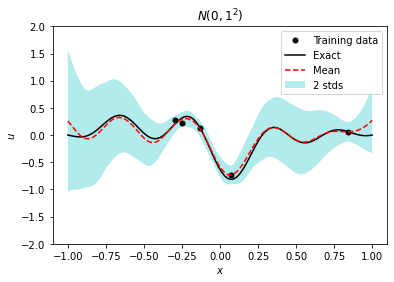

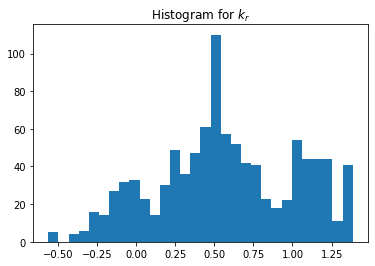

0.57273275 0.44071084


In [5]:
u_pred, k_pred = model.predict(x_test, samples, [process_u, process_k])
plot1d(x_u_train, u_train, x_test, u_test, u_pred[..., 0], ylabel="$u$", ylim=[-2.0, 2.0], title="$N(0, 1^2)$")
plt.hist(k_pred, bins=30)
plt.title("Histogram for $k_r$")
plt.show()
print(np.mean(k_pred), np.std(k_pred))

# sio.savemat(
#     "Normal.mat",
#     {
#         "x_u_train": x_u_train, "u_train": u_train,
#         "x_f_train": x_f_train, "f_train": f_train,
#         "x_test": x_test, "u_test": u_test, "f_test": f_test,
#         "u_pred": u_pred, "f_pred": f_pred, "k_pred": k_pred,
#         "noise": noise,
#     }
# )

#### Half Normal prior for $k_r$

$X\sim HalfN(0, 1^2)$ is equivalent to there exists $Z$ such that $X=|Z|, Z\sim N(0, 1^2)$. Choosing this prior for $k_r$ indicates that we at least known $k_r\geq 0$.

In [6]:
import tensorflow_probability as tfp

class HalfNormal(neuq.variables._Samplable):
    def __init__(self, sigma=1.0, shape=[], initializer=None):
        super().__init__()

        self._num_tensors = 1
        # initial value should be set to a non-negative value
        self._initial_values = [tf.constant(0.1, tf.float32)]
        if shape == []:
            # make sure constant has at least 1 dimension
            self._initial_values = [self.initial_values[0][None, ...]]
        self.dist = tfp.distributions.HalfNormal(scale=sigma)

    def log_prob(self, samples):
        # Note: here, because a constant is considered, `samples` is a list of only
        # one element.
        return self.dist.log_prob(samples[0])

In [7]:
prior_k = HalfNormal(sigma=1)

process_k = neuq.process.Process(
    surrogate=neuq.surrogates.Identity(),
    prior=prior_k,
)
# use burnin steps to tune to good acceptance rate, with random seed fixed
samples, model = build_model(process_u, process_k, burnin_steps=2000)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate:  0.633


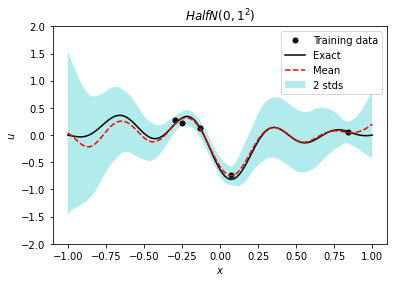

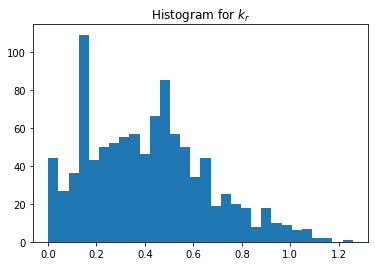

0.41312072 0.24882542


In [8]:
u_pred, k_pred = model.predict(x_test, samples, [process_u, process_k])
plot1d(x_u_train, u_train, x_test, u_test, u_pred[..., 0], ylabel="$u$", ylim=[-2.0, 2.0], title="$HalfN(0, 1^2)$")
plt.hist(k_pred, bins=30)
plt.title("Histogram for $k_r$")
plt.show()
print(np.mean(k_pred), np.std(k_pred))

# sio.savemat(
#     "HalfNormal.mat",
#     {
#         "x_u_train": x_u_train, "u_train": u_train,
#         "x_f_train": x_f_train, "f_train": f_train,
#         "x_test": x_test, "u_test": u_test, "f_test": f_test,
#         "u_pred": u_pred, "f_pred": f_pred, "k_pred": k_pred,
#         "noise": noise,
#     }
# )

#### Log Normal prior for $k_r$

$X\sim LogN(0, 1^2)$ is equivalent to $\log X\sim N(0, 1^2)$. Choosing this prior for $k_r$ indicates that we at least known $k_r\geq 0$.

In [9]:
class LogNormal(neuq.variables._Samplable):
    def __init__(self, mean, sigma=1.0, shape=[], initializer=None):
        super().__init__()

        self._num_tensors = 1
        # initial value should be set to a positive value
        self._initial_values = [tf.constant(1.0, tf.float32)]
        if shape == []:
            # make sure constant has at least 1 dimension
            self._initial_values = [self.initial_values[0][None, ...]]
        self.dist = tfp.distributions.LogNormal(loc=mean, scale=sigma)

    def log_prob(self, samples):
        # Note: here, because a constant is considered, `samples` is a list of only
        # one element.
        return self.dist.log_prob(samples[0])

In [10]:
prior_k = LogNormal(mean=0, sigma=1)

process_k = neuq.process.Process(
    surrogate=neuq.surrogates.Identity(),
    prior=prior_k,
)
samples, model = build_model(process_u, process_k, burnin_steps=2000)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate:  0.669


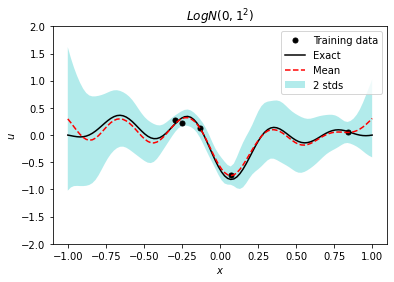

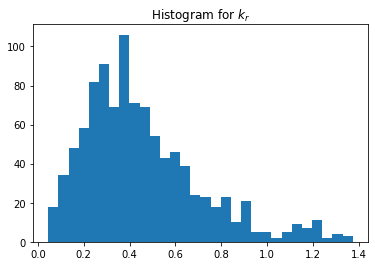

0.45376086 0.2549733


In [11]:
u_pred, k_pred = model.predict(x_test, samples, [process_u, process_k])
plot1d(x_u_train, u_train, x_test, u_test, u_pred[..., 0], ylabel="$u$", ylim=[-2.0, 2.0], title="$LogN(0, 1^2)$")
plt.hist(k_pred, bins=30)
plt.title("Histogram for $k_r$")
plt.show()
print(np.mean(k_pred), np.std(k_pred))

# sio.savemat(
#     "LogNormal.mat",
#     {
#         "x_u_train": x_u_train, "u_train": u_train,
#         "x_f_train": x_f_train, "f_train": f_train,
#         "x_test": x_test, "u_test": u_test, "f_test": f_test,
#         "u_pred": u_pred, "f_pred": f_pred, "k_pred": k_pred,
#         "noise": noise,
#     }
# )